In [87]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [88]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [89]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [90]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [91]:
x_pre = imputer.transform(dfpre)

In [92]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [93]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [94]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [95]:
# dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [96]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))


# 
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [97]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [98]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [99]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [100]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            3506 non-null   int64         
 1   Time                                  3506 non-null   datetime64[ns]
 2   LON                                   3506 non-null   float64       
 3   LAT                                   3506 non-null   float64       
 4   Temperature above oceans              3506 non-null   float64       
 5   Air density above oceans              3405 non-null   float64       
 6   Max wave height                       3152 non-null   float64       
 7   Swell period                          3152 non-null   float64       
 8   Wind wave period                      3152 non-null   float64       
 9   Wave period                           3152 non-null   float64       
 10  

Add test data for 3 months into validation data

In [102]:
# Data Splitting

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 
x_train,x_test,y_train,y_test = train_test_split(df.drop(['SOG']
                                                                 ,axis=1)
                                                                ,df.SOG,test_size=0.2,random_state=42)

In [103]:
df_test = pd.concat([x_test,y_test],axis=1)

In [104]:
# Extract three months of data from the test datasets

# Test with more data
dfdate1 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-01']
dfdate2 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-02']
dfdate3 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-03']
dfdate4 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-04']
dfdate5 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-05']
# ##########################################################################

dfdate7 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-07']
dfdate8 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-08']
dfdate9 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-09']
dfdate10 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-10']
dfdate11 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-11']
dfdate12 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-12']



# Concatenate 6 months data into df_ship

# df_months6 = pd.concat([dfdate7,dfdate8,dfdate9,dfdate10,dfdate11,dfdate12])

# Test section with more data 

df_months6 = pd.concat([dfdate1,dfdate2,dfdate3,dfdate4,dfdate5,dfdate7,dfdate8,dfdate9,dfdate10,dfdate11,dfdate12])



In [105]:
df_ship = df_months6.drop(['Unnamed: 0','LON','LAT','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction,SOG
702,273.350830,1.639553,5.229636,3.234901,4.094504,277.717895,0.854533,0.560547,0.642914,4.834130,...,167.639484,106.755485,100.890698,23.424774,57.035614,0.105747,7.899833,296.750531,177.634530,17.796529
425,277.373535,1.363195,4.333393,2.725380,3.808491,278.187500,0.717416,0.493626,0.452545,5.385540,...,6.853836,57.056116,81.702482,162.263868,121.675917,0.068111,6.477506,271.208773,155.118725,18.973217
7305,275.485107,1.207072,5.079647,2.175282,5.028988,281.692139,0.642756,0.637711,0.065796,5.470698,...,63.460148,151.271969,50.719773,118.366245,50.614403,0.208269,2.273218,235.776237,201.044120,18.584076
302,274.433594,2.649884,4.345334,4.285193,4.287695,277.633911,1.368544,0.258740,1.343628,5.289444,...,81.400359,144.552992,45.264404,96.999874,96.106695,0.256832,10.366420,20.462256,186.385110,17.367918
615,275.730713,1.330918,3.942446,3.345863,3.439272,277.380493,0.703928,0.279053,0.645996,5.379842,...,5.408478,34.711324,122.409087,171.729094,165.529997,0.028694,6.797408,286.243468,66.123666,18.056660


In [106]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [107]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [108]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

In [109]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [110]:
X = imputer.transform(df_ship2)

In [111]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [112]:
x_months6 = df_ship2tr.drop(['sog'],axis=1)
y_months6 = df_ship2tr.sog

In [113]:
print("Amount of the test dataset is:",len(x_months6))

Amount of the test dataset is: 702


Special Section

In [114]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Exporting File

In [115]:
# df.to_csv('June_update.csv')

Measure performance in one month

In [116]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,21.771601,184.345879
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,25.671971,199.414773
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,32.436488,199.442652
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,50.510505,189.415252
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,74.157471,180.552404


In [117]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [118]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [119]:
stats2 = dfdate6['curspeed'].value_counts()

In [120]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [121]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [122]:
xdate = imputer.transform(dfdate6)

In [123]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [124]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

In [125]:
print(f"Amount of the test dataset is {len(x_date)}")

Amount of the test dataset is 322


In [126]:
dfdate6.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,truenorthwinddir,truenorthcurrentdir
count,322.000000,287.000000,305.000000,287.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,287.000000,322.000000,322.000000
mean,287.133146,3.411435,287.261956,0.665559,5.282713,17.449699,197.436423,189.432992,5.832751,0.092478,86.173628,86.811052,95.744646,193.881748,155.282564
std,6.306975,1.018301,4.927599,0.572845,0.162420,3.069944,86.327689,88.499255,3.020207,0.068917,62.588681,59.359251,63.892090,89.816472,102.716811
min,269.606903,1.915993,275.485352,0.073242,4.754639,5.224523,82.664990,79.551648,0.441768,0.002006,0.565115,1.295289,0.200645,3.207821,0.112383
25%,285.292786,2.656420,286.814697,0.254164,5.199718,16.568861,103.569971,101.685445,3.442231,0.043318,24.875738,28.600108,29.381058,120.064906,83.669063
50%,289.505615,3.125275,289.625977,0.431268,5.290842,18.413643,193.360899,125.125521,5.528616,0.073482,82.212973,79.271353,104.919772,193.709354,129.304190
75%,291.391602,3.919880,290.497070,0.836488,5.381292,19.421633,283.259801,279.238872,7.569939,0.123647,149.107733,146.039105,159.782560,279.768652,249.619550
max,294.685303,6.291378,292.665649,2.565230,5.657671,21.031230,319.851509,304.969531,13.386999,0.417155,179.309007,179.405213,179.699225,357.291804,359.450078


Reverse Modelling Test 

Concatenate test and validation data 

In [127]:
x_date_c = pd.concat([x_date,x_months6])
y_date_c = pd.concat([y_date,y_months6])

In [128]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()

    score_RMSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    RMSE = -score_RMSE.mean()

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_MAD,score_RMSE    

RFR evaluation

In [129]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_date,y_date)

Model Performance of RandomForestRegressor(random_state=42)
R^2: 0.7562
explained Variance = 0.7865
MAE = 0.9594
RMSE = 1.3125
MAD = 0.7261



In [130]:
r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_hpov,x_date,y_date)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2: 0.7519
explained Variance = 0.7862
MAE = 0.9581
RMSE = 1.3207
MAD = 0.7263



In [131]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_date,y_date)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2: 0.7970
explained Variance = 0.8234
MAE = 0.9057
RMSE = 1.2205
MAD = 0.6861



In [132]:
r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_date,y_date)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2: 0.8095
explained Variance = 0.8324
MAE = 0.8844
RMSE = 1.1892
MAD = 0.6730



In [133]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr_ftr,x_date,y_date)

Model Performance of DecisionTreeRegressor()
R^2: 0.6778
explained Variance = 0.7810
MAE = 1.0268
RMSE = 1.5316
MAD = 0.7610



In [134]:
r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_date,y_date)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2: 0.7209
explained Variance = 0.7431
MAE = 1.0421
RMSE = 1.4625
MAD = 0.7356



In [135]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr_ftr,x_date,y_date)

Model Performance of LinearRegression()
R^2: 0.3935
explained Variance = 0.4096
MAE = 1.4308
RMSE = 1.9116
MAD = 1.2237



Experiment on amount of data effectiveness

In [136]:
print(f"Combined data length of June data + 6 months is {len(x_date_c)}")

Combined data length of June data + 6 months is 1024


In [137]:
# r2_rfc,expVar_rfc,MAE_rfc,RMSE_rfc,MAD_rfc = evaluate(model_rfr_ftr,x_date_c,y_date_c)

In [138]:
# r2_rfco,expVar_rfco,MAE_rfco,RMSE_rfco,MAD_rfco = evaluate(model_rfr_hpov,x_date_c,y_date_c)

In [139]:
# r2_etc,expVar_etc,MAE_etc,RMSE_etc,MAD_etc = evaluate(model_etr,x_date_c,y_date_c)

In [140]:
# r2_etco,expVar_etco,MAE_etco,RMSE_etco,MAD_etco = evaluate(model_etr_hpov,x_date_c,y_date_c)

In [141]:
# r2_dtc,expVar_dtc,MAE_dtc,RMSE_dtc,MAD_dtc = evaluate(model_dtr_ftr,x_date_c,y_date_c)

In [142]:
# r2_dtco,expVar_dtco,MAE_dtco,RMSE_dtco,MAD_dtco = evaluate(model_dtr_hpov,x_date_c,y_date_c)

In [143]:
# r2_mlrc,expVar_mlrc,MAE_mlrc,RMSE_mlrc,MAD_mlrc = evaluate(model_mlr_ftr,x_date_c,y_date_c)

In [144]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.1f}x {b:+.1f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$m/s$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$m/s$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()



0.7930691573886957
y = 0.9 * x + 1.9
0.8451332064434847
y = 0.8 * x + 2.3


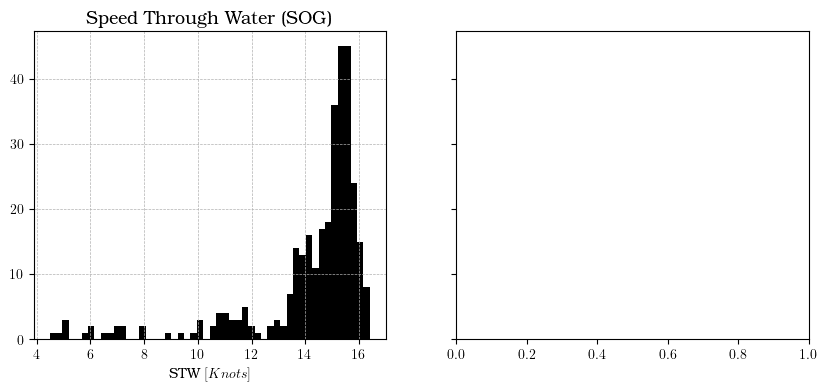

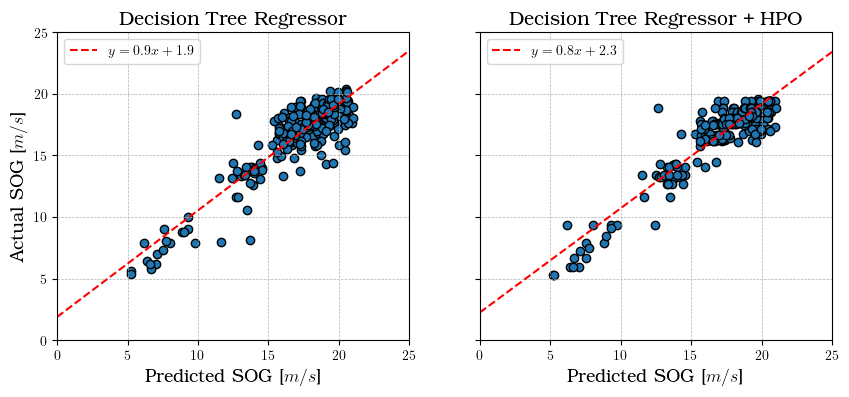

In [145]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8641250686489151
y = 0.8 * x + 2.2
0.8669620381079686
y = 0.8 * x + 2.3


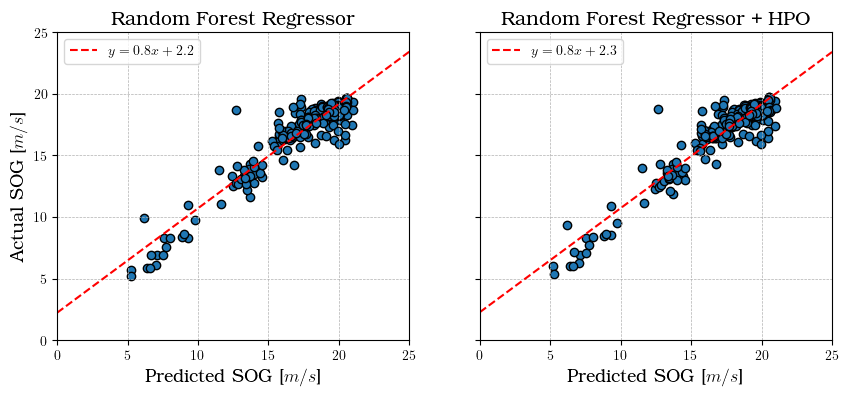

In [146]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8743301165173356
y = 0.9 * x + 2.2
0.8731763195782185
y = 0.8 * x + 2.3


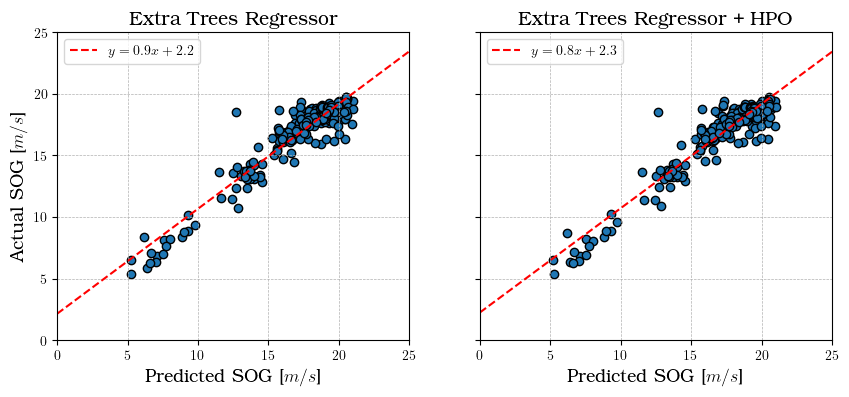

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

Evaluation using Cross Validation

<Figure size 500x300 with 0 Axes>

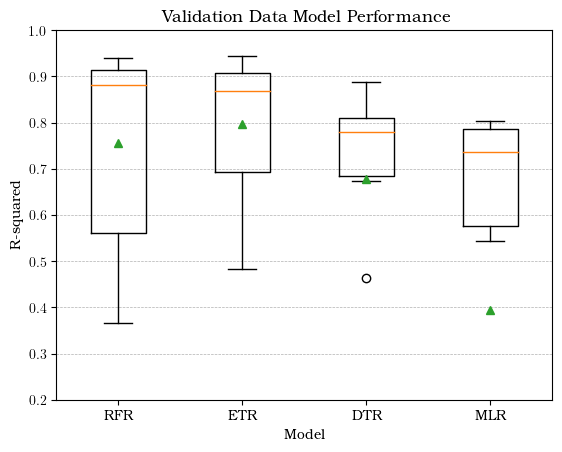

In [148]:
scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

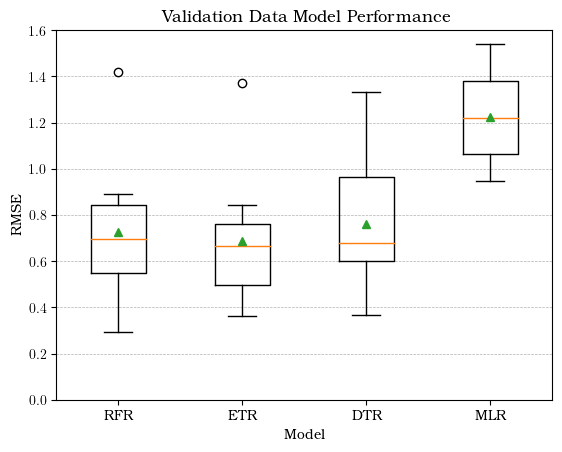

In [149]:
scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

Optimization comparison

<Figure size 500x300 with 0 Axes>

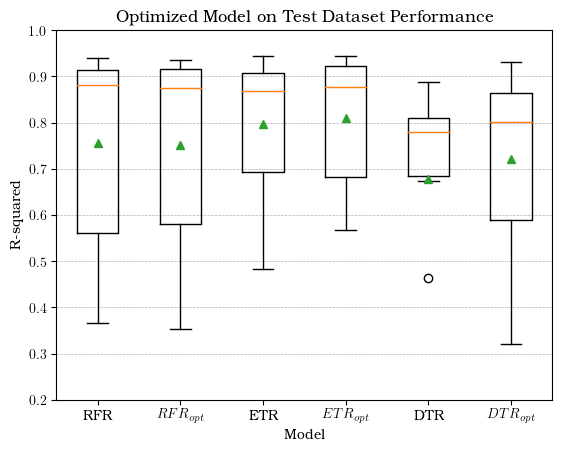

In [150]:
scores_opt = [r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model on Test Dataset Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.ylim(0.2,1.0)
plt.yscale('linear')
ax.boxplot(scores_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

<Figure size 500x300 with 0 Axes>

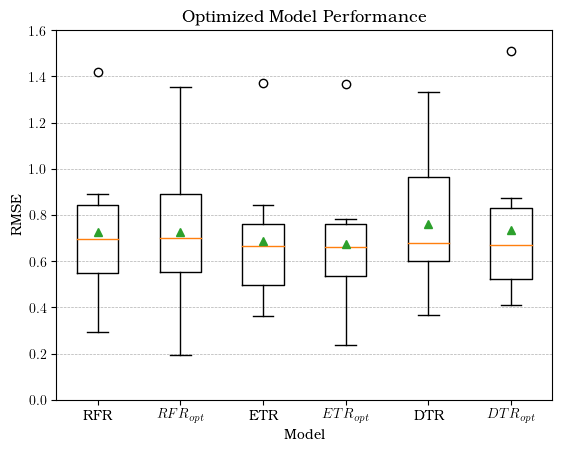

In [151]:
rmse_opt = [-RMSE_rf,-RMSE_rfo,-RMSE_et,-RMSE_eto,-RMSE_dt,-RMSE_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
ax.boxplot(rmse_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

In [152]:
# scores_opt = [r2_rf,r2_rfc,r2_et,r2_etc,r2_dt,r2_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of amount of data")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [153]:
# rmse_opt = [-RMSE_rf,-RMSE_rfc,-RMSE_et,-RMSE_etc,-RMSE_dtc,-RMSE_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of Amount of Data")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
plt.show()

In [154]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

STW Calculation

In [409]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

ydate_pred = label_predict(model_rfr_hpov,x_date)
 
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred       gamma    nwinddir
119   18.998906  18.502608  184.345879   21.771601
120   19.334278  18.685107  199.414773   25.671971
121   18.911047  18.547404  199.442652   32.436488
122   13.854933  13.942330  189.415252   50.510505
126    9.305198  10.907485  180.552404   74.157471
...         ...        ...         ...         ...
7413  19.072622  18.294820  104.966166  110.959927
7414  17.696584  17.628170   86.330174  126.837339
7415  15.963630  16.571597   83.486098  119.018621
7418   8.988086   8.643221   89.745593  140.723377
7419  17.672769  17.420793   15.792214  143.902554

[322 rows x 4 columns]


In [410]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,164.871808,57.268527,18.998906,18.502608,184.345879,21.771601
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,153.650411,51.313932,19.334278,18.685107,199.414773,25.671971
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,153.031589,46.894106,18.911047,18.547404,199.442652,32.436488
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,153.643227,56.527939,13.854933,13.942330,189.415252,50.510505
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,41.766758,167.192888,9.305198,10.907485,180.552404,74.157471
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,36.203894,119.939682,20.935741,17.415279,184.264563,72.289134
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,16.745666,176.253205,12.419853,12.283646,182.129556,60.000273
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,148.640604,54.778275,20.447721,16.442690,275.295245,68.405148
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,154.901600,41.385363,18.702889,16.712618,187.199243,84.710374
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,10.961510,159.775304,16.155258,16.319275,281.621166,89.075598


In [411]:
# Conversion of predicted SOG to m/s

dfprog["vgms"] = dfprog["sog_pred"]/1.9438

# Conversion of actual SOG to m/s

dfprog["vgms_act"] = dfprog["sog_act"]/1.9438

In [412]:
# Conversion of the angles to radian

rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["heading"])

In [413]:
# Calculation of the predicted x-component of SOG

dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

# Calculation of the actual x-component of SOG

dfprog["vgx_act"] = dfprog["vgms_act"] * np.sin(rad_cog)
dfprog["stw_x_act"] = (dfprog["vgx_act"] - dfprog["vcx"])


In [414]:
# Calculation of the predicted y-component of SOG 

dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

# Calculation of the actual y-component of SOG

dfprog["vgy_act"] = dfprog["vgms_act"] * np.cos(rad_cog)
dfprog["stw_y_act"] = (dfprog["vgy_act"] - dfprog["vcy"])


In [415]:
# For the actual data
# Try apply correction factor so that maximum is 17.7 kts is not exceeded, apply 0.85*STW to correct for maximum operating speed 
# Model have tendecy to 'undepredict'

dfprog["vwms_a"] = np.sqrt(dfprog["stw_x_act"]**2 + dfprog["stw_y_act"]**2)
dfprog["stw_act"] = dfprog["vwms_a"]*1.9438

# For the prediction

dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = (dfprog["vwms_p"]*1.9438)*0.85

# /1.1922

In [416]:
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vgms_act','vgx_act','stw_x_act',
                      'vgy_act','stw_y_act',
                      'vwms_p','vwms_a'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,164.871808,57.268527,18.998906,18.502608,184.345879,21.771601,18.969394,15.702179
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,153.650411,51.313932,19.334278,18.685107,199.414773,25.671971,19.443319,15.975190
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,153.031589,46.894106,18.911047,18.547404,199.442652,32.436488,19.032848,15.868951
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,153.643227,56.527939,13.854933,13.942330,189.415252,50.510505,13.790601,11.796234
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,41.766758,167.192888,9.305198,10.907485,180.552404,74.157471,8.965348,8.981482
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,36.203894,119.939682,20.935741,17.415279,184.264563,72.289134,21.101875,14.944595
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,16.745666,176.253205,12.419853,12.283646,182.129556,60.000273,12.234448,10.283607
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,148.640604,54.778275,20.447721,16.442690,275.295245,68.405148,20.756085,14.238568
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,154.901600,41.385363,18.702889,16.712618,187.199243,84.710374,18.656604,14.166559
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,10.961510,159.775304,16.155258,16.319275,281.621166,89.075598,15.889716,13.645672


In [417]:
dfprog.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,3.400343,287.256948,0.661506,5.282713,197.436423,189.432992,5.832751,0.092478,86.173628,86.811052,96.072486,17.449699,17.023647,155.282564,193.881748,17.464548,14.482740
std,6.306975,0.965020,4.797442,0.541832,0.162420,86.327689,88.499255,3.020207,0.068917,62.588681,59.359251,62.354792,3.069944,2.752009,102.716811,89.816472,3.085176,2.357929
min,269.606903,1.915993,275.485352,0.073242,4.754639,82.664990,79.551648,0.441768,0.002006,0.565115,1.295289,0.200645,5.224523,5.419481,0.112383,3.207821,5.173749,4.567198
25%,285.292786,2.692099,286.832031,0.272528,5.199718,103.569971,101.685445,3.442231,0.043318,24.875738,28.600108,30.508970,16.568861,16.631958,83.669063,120.064906,16.597074,14.161381
50%,289.505615,3.160003,289.004578,0.474936,5.290842,193.360899,125.125521,5.528616,0.073482,82.212973,79.271353,102.070984,18.413643,18.041224,129.304190,193.709354,18.410172,15.385566
75%,291.391602,3.764453,290.458008,0.788779,5.381292,283.259801,279.238872,7.569939,0.123647,149.107733,146.039105,158.513351,19.421633,18.598562,249.619550,279.768652,19.452246,15.853048
max,294.685303,6.291378,292.665649,2.565230,5.657671,319.851509,304.969531,13.386999,0.417155,179.309007,179.405213,179.699225,21.031230,19.725687,359.450078,357.291804,21.101875,16.731119


Integration of Holtrop Mennen Estimations

In [418]:
import numpy as np
import math
import pandas as pd

# List of basic ship information

loa = 158 # ship overall length
lwl = 144.8 # ship waterline length, m
lpp = 0.97*lwl # ship perpendicular length , m, according to information
B = 24.5 # Ship B, m
depth = 13.8 # Ship depth. m
T_n = 5.85 # Nominal max draught , m
dwt = 5110 # ship dead weight , t
V_n = 17.7 # ship design speed, knots

#list of constants

g = 9.805 # gravity, kg/ms^2 
rho_sea = 1025 # kg/m3
nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
dfprog['stw_pred_ms'] = dfprog['stw_pred'] / 1.94384
# Calculation for C_b according to Schneekluth and Bertram 1998
# first calculate froude number Fn
V_n = 17.7/1.94384
Fr_n = V_n / math.sqrt(g*lpp)
print(f"Froude Number {Fr_n:0.4f}")
C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
print(f"C_b {C_b:0.4f}")

# calculation for C_m according to charchalis 2017

C_m = 0.977 + 0.085*(C_b-0.6)
print(f"C_m {C_m:0.4f}")

# prismatic coefficient C_p can be calculated

C_p = C_b/C_m 
print(f"C_p {Fr_n:0.4f}")

# Displacement calculation according to barras
# Use approximate value cd=0.35 according to Barras

dsp = dwt/0.35 # m^3
print(f"dsp {dsp:0.4f} m^3")

# coefficient c14 to account for stern shape according to holtrop mennen

C_stern = 10 # assume u shaped stern
c14 = 1 + 0.011*C_stern 
print(f"c14 {c14:0.4f}")

# Calculate length of run according to holtrop mennen

lcb = -2/100 # ratio lcb wrt to amidship ford, value from barras
# L in holtrop mennen is lwl
lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))
print(f"lr {lr:0.4f} m")

# now the (1+k1) can be calculated

k1a = 0.487118*c14*(B/lwl)**1.06806
k1b = (T_n/lwl)**0.46106
k1c = (lwl/lr)**0.121563
k1d = (lwl**3/dsp)**0.36486
k1e = (1-C_p)**-0.604247

k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

print(f"k1_const {k1_const:0.4f}")
# we can then calculate R_f
import pandas as pd
import numpy as np
# use v mean = 10 for Reynold


dfprog['Re'] =( dfprog['stw_pred_ms'] * lwl ) / nu_sea
dfprog['C_f'] = 0.075 / (np.log10(dfprog['Re']-2)**2)
# print(dfprog['Re'])
# print(dfprog['C_f'])

# calculate appendage area of bare hull S_bh

# first calculate C_wp acc. to schneekluth and bertram
C_wp = (1+2*C_b)/3
print(f"C_wp {C_wp:0.4f}")

# A_bt according to kim

A_m = B*T_n*C_m
A_t = 0.051 * A_m
A_bt = 0.08*A_m
print(f"A_m {A_m:0.4f} m^2")
print(f"A_t {A_t:0.4f} m^2")
print(f"A_bt {A_bt:0.4f} m^2")


sbh_a = lwl*(2*T_n+B)*math.sqrt(C_m)
sbh_b = 0.453
sbh_c = 0.4425*C_b
sbh_d = 0.2862*C_m
sbh_e = 0.003467*(B/T_n)
sbh_f = 0.3696*C_wp
sbh_g = 2.38*A_bt/C_b

S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g
print(f"S_bh {S_bh:0.4f} m^2")

dfprog['R_f'] = 0.5 * rho_sea * (dfprog['stw_pred_ms'])**2 * dfprog['C_f'] * S_bh * k1_const
# print(dfprog['R_f'])


# Now resistance due to appendage
# Assume Sapp

S_app = 50 # m^2 
# from holtrop mennen
k2_const = 2.8

dfprog['R_app'] = 0.5 * rho_sea * (dfprog['stw_pred_ms'])**2 * (dfprog['C_f']) * S_app *k2_const
# print(dfprog['R_app'])

# print(B/lwl)
# print(lwl/B)
# print(lwl**3/dsp)
# calculate wave resistance
c7 = B/lwl
T_fwd = T_n # assume !
h_b = 0.6*T_fwd
c3 = 0.56 * A_bt**1.5 / (B*T_n*(0.31*math.sqrt(A_bt)+T_fwd-h_b))
# print(c3)
c2 = math.exp(-1.89*math.sqrt(c3))
# print(c2)
c5 = 1 - 0.8*(A_t/(B*T_n*C_m))
# print(c5)
lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
# print(lambda_const)
c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
# print(c16)
m_1 = 0.0140407 * (lwl/T_n) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
# print(m_1)
c15 = -1.69385
# Use dynamic Froude here
dfprog['Fr_n'] = dfprog['stw_pred_ms'] / math.sqrt(g*lpp)
dfprog['m_2'] = c15 * C_p**2 * np.exp(-0.1*dfprog['Fr_n']**-2)
# print(dfprog['m_2'])
i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
# print(i_e)
c1 = 2223105 * c7**3.78613 * (T_n/B)**1.07961*(90-i_e)**-1.37565
# print(c1)
d = -0.9

dfprog['R_w'] = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*dfprog['Fr_n']**d+dfprog['m_2']*np.cos(lambda_const*dfprog['Fr_n']**-2))
# print(dfprog['R_w'])

# resistance due to bulbous bow
# use V = 10 m/s

P_b = 0.56*math.sqrt(A_bt)/(T_fwd-1.5*h_b)
# print(P_b)
dfprog['F_ni'] = dfprog['stw_pred_ms'] / np.sqrt(g*(T_fwd-h_b-0.25*math.sqrt(A_bt))+0.15*dfprog['stw_pred_ms']**2)
dfprog['R_b'] = 0.11 * np.exp(-3*P_b**-2)*dfprog['F_ni']**3*A_bt**1.5*rho_sea*g/(1+dfprog['F_ni']**2)
# print(dfprog['R_b'])
#Calculate Transom Resistance 
# use v = 10

F_nT = 10 / math.sqrt(2*g*A_t/(B+B*C_wp))
print(f"Froude for Transom {F_nT:0.4f}")
# Due to condition set by holtrop mennen c6 = 0
c6 = 0
R_tr = 0.5*rho_sea*10**2*A_t*c6
print(f"R_tr = {R_tr:0.4f} N")
# Model ship correlation resistance

c4 = T_fwd/lwl
# print(c4)
# since c4>0.04, use c4 as c4 = 0.04
c4 = 0.04
C_a = 0.006*(lwl+100)**-0.16 - 0.00205 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)
# print(C_a)
dfprog['R_a'] = 0.5*rho_sea*dfprog['stw_pred_ms']**2*S_bh*C_a
# print(dfprog['R_a'])

# Calculate Rtot

dfprog['R_tot'] = dfprog['R_f'] + dfprog['R_app'] + dfprog['R_w'] + dfprog['R_b'] + dfprog['R_a'] 
dfprog['R_tot'] = dfprog['R_tot'] / 1e3
# dfprog.head()
df_prog=dfprog.drop(['C_f','Re','F_ni'],axis=1)
# Calculate Efficiencies

# First n_h
# Approximate diameter size from Bertram

D = 0.215*16 #m
# D = 8
# print(D)
# print(C_b)
# print(k1_const)
# print(B)
# print(T_n)

dfprog['C_v'] = k1_const*dfprog['C_f'] + C_a
# print(dfprog['C_v'])
dfprog['w'] = 0.3095 * C_b + 10*dfprog['C_v']*C_b - (0.23*D)/math.sqrt(B*T_n) 
# print(dfprog['w'])
dfprog['t'] = 0.325*C_b - 0.1885*D/math.sqrt(B*T_n)
# print(dfprog['t'])
dfprog['eff_h'] = (1-dfprog['t']) / (1-dfprog['w'])
# print(dfprog['eff_h'])

# Then n_r
dfprog['eff_r'] = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*lcb
# print(dfprog['eff_r'])

dfprog['eff_s'] = 0.99 # Set according to holtrop mennen and man
dfprog['eff_o'] = 0.75 # Approx wageningen kristensen

dfprog['eff_tot'] = dfprog['eff_h']* dfprog['eff_r']* dfprog['eff_s']*dfprog['eff_o']*0.85 # consider sea margin
# print(df_prog)
dfprog['P_b'] = (dfprog['R_tot'] * dfprog['stw_pred_ms'])/dfprog['eff_tot'] # in kW
# dfprog.head()
# Unit P_b is KW
SFOC = 169.4 # g/kWh
dfprog['FOC'] = (dfprog['P_b'] * SFOC)/1e6 # get FOC t/h
dfprog.head()


Froude Number 0.2454
C_b 0.6451
C_m 0.9808
C_p 0.2454
dsp 14600.0000 m^3
c14 1.1100
lr 49.4890 m
k1_const 1.2119
C_wp 0.7634
A_m 140.5784 m^2
A_t 7.1695 m^2
A_bt 11.2463 m^2
S_bh 3958.0019 m^2
Froude for Transom 5.5434
R_tr = 0.0000 N


,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,...,C_v,w,t,eff_h,eff_r,eff_s,eff_o,eff_tot,P_b,FOC
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,...,0.001562,0.143656,0.155506,0.986162,1.048474,0.99,0.75,0.652561,3677.801227,0.623020
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,...,0.001560,0.143644,0.155506,0.986148,1.048474,0.99,0.75,0.652552,3937.962724,0.667091
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,...,0.001560,0.143648,0.155506,0.986154,1.048474,0.99,0.75,0.652556,3836.360241,0.649879
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,...,0.001593,0.143860,0.155506,0.986398,1.048474,0.99,0.75,0.652717,1421.671782,0.240831
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,...,0.001625,0.144063,0.155506,0.986631,1.048474,0.99,0.75,0.652872,640.980268,0.108582


In [419]:
dfprog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 119 to 7419
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     322 non-null    float64
 1   waveperiod           322 non-null    float64
 2   surftemp             322 non-null    float64
 3   windwaveswellheight  322 non-null    float64
 4   draught              322 non-null    float64
 5   cog                  322 non-null    float64
 6   heading              322 non-null    float64
 7   windspeed            322 non-null    float64
 8   curspeed             322 non-null    float64
 9   truewinddir          322 non-null    float64
 10  truecurrentdir       322 non-null    float64
 11  truewavedir          322 non-null    float64
 12  sog_act              322 non-null    float64
 13  sog_pred             322 non-null    float64
 14  gamma                322 non-null    float64
 15  nwinddir             322 non-null    

In [420]:
dfprog_f = dfprog.drop(['Re','C_f','Fr_n','m_2','F_ni','C_v','w','t','sog_act','stw_act','stw_pred_ms'],axis=1)

In [421]:
print(dfprog_f.describe())
stats = dfprog_f.describe()

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        322.000000  322.000000  322.000000           322.000000   
mean         287.133146    3.400343  287.256948             0.661506   
std            6.306975    0.965020    4.797442             0.541832   
min          269.606903    1.915993  275.485352             0.073242   
25%          285.292786    2.692099  286.832031             0.272528   
50%          289.505615    3.160003  289.004578             0.474936   
75%          291.391602    3.764453  290.458008             0.788779   
max          294.685303    6.291378  292.665649             2.565230   

          draught         cog     heading   windspeed    curspeed  \
count  322.000000  322.000000  322.000000  322.000000  322.000000   
mean     5.282713  197.436423  189.432992    5.832751    0.092478   
std      0.162420   86.327689   88.499255    3.020207    0.068917   
min      4.754639   82.664990   79.551648    0.441768    0.002006   
25%   

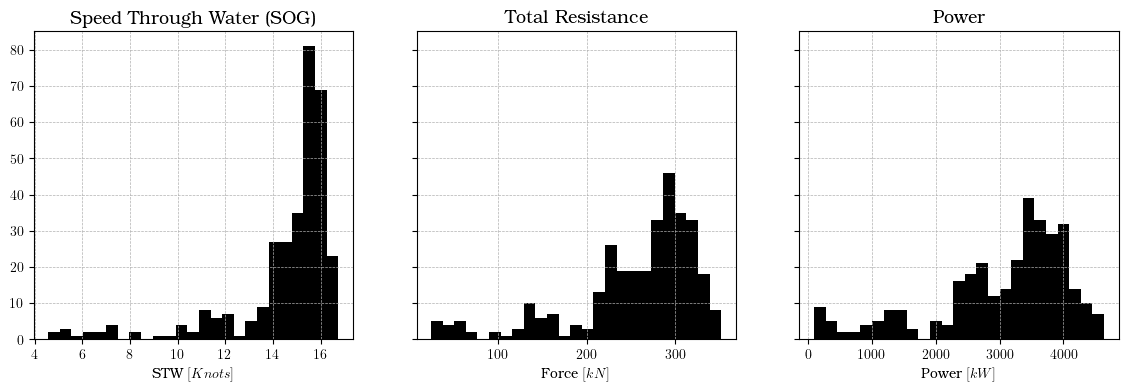

In [422]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True)
plt.sca(axes[0])
dfprog_f['stw_pred'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"STW $[Knots]$")
plt.title(r"Speed Through Water (SOG)", fontsize=13)
plt.sca(axes[1])
dfprog_f['R_tot'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"Force $[kN]$")
plt.title(r"Total Resistance", fontsize=13)
plt.ylabel("")
plt.sca(axes[2])
dfprog_f['P_b'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"Power $[kW]$")
plt.title(r"Power", fontsize=13)
plt.ylabel("")
plt.show()

In [423]:
# # FOC in T/d
# dfprog["foc_act_d"] = ((dfprog["stw_act"]/17.7)**3) * 21.14112
# dfprog["foc_pred_d"] = ((dfprog["stw_pred"]/17.7)**3) * 21.14112

# # FOC in T/h
# dfprog["foc_act_h"] = ((dfprog["stw_act"]/17.7)**3) * 0.8808
# dfprog["foc_pred_h"] = ((dfprog["stw_pred"]/17.7)**3) * 0.8808

In [424]:
# dfprog.head(n=10)

In [425]:
# # df_foc=dfprog.drop(['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod',
# #                     'surftemp','windwaveswellheight','swellheight','windwaveheight','swellheight',
# #                     'windwaveheight','draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir',
# #                     'truewavedir','gamma','nwinddir'],axis=1)

# df_foc=dfprog.drop(['oceantemperature','waveperiod',
#                     'surftemp','windwaveswellheight',
#                     'draught','cog','heading','windspeed','curspeed',
#                     'truewavedir'],axis=1)

In [426]:
# import matplotlib.pyplot as plt
# plt.rcParams.update(plt.rcParamsDefault)
# df_foc.hist(bins=100,figsize=(20,15))
# plt.show()

In [427]:
# foc_month = dfprog['foc_pred_d'].mean()
# foc_month_a = dfprog['foc_act_d'].mean()
# print(f"Mean of predicted FOC in a month is {foc_month} T/d")
# print(f"Mean of actual FOC in a month is {foc_month_a} T/d")

In [428]:
# foc_trip = dfprog['foc_pred_h'].mean() * 4
# foc_trip_a = dfprog['foc_act_h'].mean() * 4
# foc_trip_err = foc_trip_a - foc_trip
# print(f"Mean of predicted FOC in a 4h trip is {foc_trip} T")
# print(f"Mean of actual FOC in a trip in a 4h trip is {foc_trip_a} T")
# print(f"Error is {foc_trip_err} T")

In [429]:
# plt.figure(figsize=(10,10))
# plt.scatter(dfprog['stw_pred'], dfprog['stw_act'], c='crimson')
# # plt.yscale('log')
# # plt.xscale('log')

# p1 = max(max(dfprog['stw_pred']), max(dfprog['stw_act']))
# p2 = min(min(dfprog['stw_pred']), min(dfprog['stw_act']))
# plt.plot([p1, p2], [p1, p2], 'b-')
# # plt.xscale('linear')
# plt.xlim(0,25)
# plt.ylim(0,30)
# plt.xlabel('STW', fontsize=15)
# plt.ylabel('FOC', fontsize=15)
# # plt.axis('equal')
# plt.show()

In [430]:
# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c

In [431]:
# # fit a second degree polynomial to the economic data
# from numpy import arange
# from scipy.optimize import curve_fit

# plt.figure(figsize=(10,10))

# # define the true objective function
# def objective(x, a, b ):
# 	return a * x + b

# # choose the input and output variables
# x, y = dfprog.stw_pred, dfprog.stw_act
# # x2, y2 = dfprog.stw_pred, dfprog.foc_pred_d
# # curve fit
# popt, _ = curve_fit(objective, x, y)
# # popt2, _ = curve_fit(objective, x2, y2)

# # summarize the parameter values
# a, b = popt
# print('y = %.5f * x + %.5f' % (a, b ))
# # a2, b2, c2 = popt2
# # print('y = %.5f * x + %.5f * x^2 + %.5f' % (a2, b2, c2))
# # plot input vs output
# plt.scatter(x, y)
# # plt.scatter(x2, y2)
# # define a sequence of inputs between the smallest and largest known inputs
# x_line = arange(min(x), max(x), 1)
# # x_line2 = arange(min(x), max(x), 1)
# # calculate the output for the range
# y_line = objective(x_line, a, b)
# # y_line2 = objective(x_line2, a2, b2, c2)
# # create a line plot for the mapping function
# plt.plot(x_line, y_line, color='red')
# # plt	.plot(x_line2, y_line2, color='green')
# plt.xlabel('STWpred', fontsize=15)
# plt.ylabel('STWact', fontsize=15)
# plt.show()

y = 1.06917 * x + -0.72944

linear y = 0.96885 * x + 0.96831

